First I'm mounting my Google drive to load data

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Colab Notebooks"

Now let's prepare imports and glove embedding

In [2]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-09-08 18:23:30--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-09-08 18:23:30--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-09-08 18:23:30--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as layers
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
class GloveEmbeddings(layers.Layer):
  def __init__(self, embedding_dim, trainable, tokenizer):
    """
    embedding_dim - embedding dimension, we can choose 50, 100, 200 or 300
    trainable - if True embedding will be modified during training, 
    tokenizer - tokenizer reference

    code adapted from https://keras.io/examples/nlp/pretrained_word_embeddings/
    """
    super().__init__()

    path_to_glove_file = f"glove.6B.{embedding_dim}d.txt"
    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))


    num_tokens = len(tokenizer.index_word) + 2
    hits = 0
    misses = 0

    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    self.embedding = layers.Embedding(input_dim=num_tokens, output_dim=embedding_dim,
                                      embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=trainable)
    
  def call(self, inputs, training=False):
    """
    in: [batch size x seq len]
    out: [batch size x seq len x embedding_dim]
    """
    return self.embedding(inputs, training=training)

In [4]:
#loading data
toxic = pd.read_csv("/content/drive/My Drive/Colab Notebooks/toxic_comments.csv")

In [ ]:
#how the data looks like
toxic.head(10)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.000000,0.021277,0.872340,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.000000,4,47
5,59859,0.666667,ur a sh*tty comment.,0.047619,0.638095,0.000000,0.333333,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.009524,0,105
6,59861,0.457627,hahahahahahahahhha suck it.,0.050847,0.305085,0.000000,0.254237,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.220339,0,59
7,59863,0.000000,FFFFUUUUUUUUUUUUUUU,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
8,239575,0.000000,The ranchers seem motivated by mostly by greed...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,26662,approved,0,0,0,0,0,0.000000,0,4
9,239576,0.000000,It was a great show. Not a combo I'd of expect...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,26650,approved,0,0,0,1,0,0.000000,0,4


First I will build model to a classification model, therefore I must change target to 0 and 1

In [ ]:
toxic['binary_target'] = toxic['target'].apply(lambda target: 1 if target>=0.5 else 0)
toxic['binary_target'].value_counts()

0    1660540
1     144334
Name: binary_target, dtype: int64

In [ ]:
#it is inbalanced data so I will use under sampling
toxic_data = toxic[["comment_text", 'binary_target']]
shuffled_toxic = toxic_data.sample(frac=1,random_state=42)
tox_df = shuffled_toxic.loc[shuffled_toxic['binary_target'] == 1]
no_tox_df = shuffled_toxic.loc[shuffled_toxic['binary_target'] == 0].sample(n=144334,random_state=42)
normalized_toxic = pd.concat([tox_df, no_tox_df])

In [ ]:
normalized_toxic['binary_target'].value_counts()

1    144334
0    144334
Name: binary_target, dtype: int64

In [ ]:
#  let's create train and test set
y = normalized_toxic['binary_target'].values
X = normalized_toxic['comment_text'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({1: 115467, 0: 115467})
Testing target statistics: Counter({1: 28867, 0: 28867})


In [ ]:
X_train[0]

"130mph? Throw his ass in jail...then throw away the key.  Nothing else seems to get these punks attention. Oh, I know...his momma says he's actually a good boy who would never harm a flea."

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


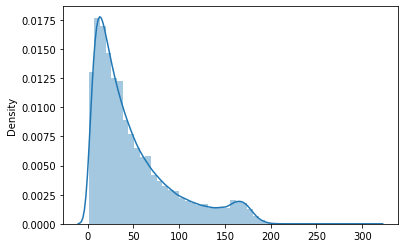

In [ ]:
#Now, we will see how long are words in our train set
train_lens = [len(x.split()) for x in X_train]
ax = sns.distplot(train_lens)

#it seems that max length 200 will be right choice

In [ ]:
#preparing data for model
tokenizer = Tokenizer(num_words=15000, lower=True)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_test)

X_train_seq = pad_sequences(X_train_seq, maxlen=200, padding='pre', truncating='pre') # pre or post
X_val_seq = pad_sequences(X_val_seq, maxlen=200, padding='pre', truncating='pre') # pre or post

In [ ]:
#first model with Glovo embeddings
model = keras.Sequential()

model.add(GloveEmbeddings(embedding_dim=200, trainable=False, tokenizer=tokenizer))
model.add(layers.Bidirectional(layers.LSTM(40)))
model.add(layers.Dense(1, activation='sigmoid'))

adam = keras.optimizers.Adam(learning_rate=0.001) # 
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

Found 400000 word vectors.
Converted 71604 words (58620 misses)


In [ ]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

h = model.fit(x=X_train_seq, y=y_train, batch_size=512, epochs=100, validation_data=(X_val_seq, y_test),
               callbacks=[es_callback])

Epoch 1/100
452/452 [==============================] - 23s 40ms/step - loss: 0.4334 - accuracy: 0.8003 - val_loss: 0.3690 - val_accuracy: 0.8407
Epoch 2/100
452/452 [==============================] - 18s 40ms/step - loss: 0.3423 - accuracy: 0.8530 - val_loss: 0.3311 - val_accuracy: 0.8582
Epoch 3/100
452/452 [==============================] - 18s 40ms/step - loss: 0.3181 - accuracy: 0.8649 - val_loss: 0.3143 - val_accuracy: 0.8670
Epoch 4/100
452/452 [==============================] - 18s 39ms/step - loss: 0.3043 - accuracy: 0.8721 - val_loss: 0.3057 - val_accuracy: 0.8709
Epoch 5/100
452/452 [==============================] - 18s 39ms/step - loss: 0.2944 - accuracy: 0.8769 - val_loss: 0.3036 - val_accuracy: 0.8734
Epoch 6/100
452/452 [==============================] - 18s 39ms/step - loss: 0.2870 - accuracy: 0.8811 - val_loss: 0.2971 - val_accuracy: 0.8768
Epoch 7/100
452/452 [==============================] - 18s 39ms/step - loss: 0.2807 - accuracy: 0.8840 - val_loss: 0.2936 - val_ac

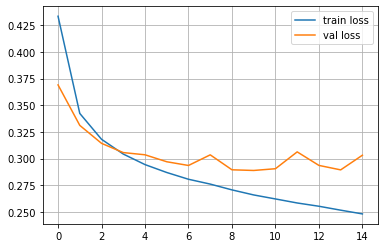

In [ ]:
steps = range(len(h.history['loss']))
plt.plot(steps, h.history['loss'], label='train loss')
plt.plot(steps, h.history['val_loss'], label='val loss')
plt.legend()
plt.grid()

It looks like model is overfitted - next model will be with Dropout layers

In [ ]:
#second model with Glove embeddings and dropout layers
model1 = keras.Sequential()

model1.add(GloveEmbeddings(embedding_dim=200, trainable=False, tokenizer=tokenizer))
model1.add(layers.Bidirectional(layers.LSTM(30,return_sequences=True)))  
model1.add(layers.Dropout(0.3)) 
model1.add(layers.LSTM(30)) 
model1.add(layers.Dropout(0.2)) 
model1.add(layers.Dense(1, activation='sigmoid'))

adam = keras.optimizers.Adam(learning_rate=0.001)
model1.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

Found 400000 word vectors.
Converted 71604 words (58620 misses)


In [ ]:
h1 = model1.fit(x=X_train_seq, y=y_train, batch_size=512, epochs=100, validation_data=(X_val_seq, y_test),
               callbacks=[es_callback])

Epoch 1/100
452/452 [==============================] - 67s 55ms/step - loss: 0.4460 - accuracy: 0.7970 - val_loss: 0.3653 - val_accuracy: 0.8436
Epoch 2/100
452/452 [==============================] - 22s 49ms/step - loss: 0.3530 - accuracy: 0.8479 - val_loss: 0.3270 - val_accuracy: 0.8609
Epoch 3/100
452/452 [==============================] - 22s 49ms/step - loss: 0.3233 - accuracy: 0.8636 - val_loss: 0.3121 - val_accuracy: 0.8685
Epoch 4/100
452/452 [==============================] - 22s 49ms/step - loss: 0.3104 - accuracy: 0.8701 - val_loss: 0.3070 - val_accuracy: 0.8713
Epoch 5/100
452/452 [==============================] - 22s 49ms/step - loss: 0.2977 - accuracy: 0.8764 - val_loss: 0.2954 - val_accuracy: 0.8778
Epoch 6/100
452/452 [==============================] - 22s 49ms/step - loss: 0.2896 - accuracy: 0.8806 - val_loss: 0.2962 - val_accuracy: 0.8768
Epoch 7/100
452/452 [==============================] - 22s 49ms/step - loss: 0.2839 - accuracy: 0.8835 - val_loss: 0.2875 - val_ac

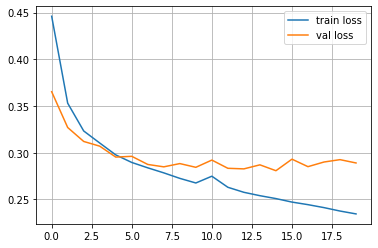

In [ ]:
steps = range(len(h1.history['loss']))
plt.plot(steps, h1.history['loss'], label='train loss')
plt.plot(steps, h1.history['val_loss'], label='val loss')
plt.legend()
plt.grid()

Second model has higher accuracy for validation set, but difference isn't big

In [ ]:
#third model with trainable Glove embeddings 
model2 = keras.Sequential()

model2.add(GloveEmbeddings(embedding_dim=200, trainable=True, tokenizer=tokenizer))
model2.add(layers.Bidirectional(layers.LSTM(30,return_sequences=True)))
model2.add(layers.Dropout(0.5))
model2.add(layers.Bidirectional(layers.LSTM(30)))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(1, activation='sigmoid'))

adam = keras.optimizers.Adam(learning_rate=0.001) # 
model2.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

Found 400000 word vectors.
Converted 71604 words (58620 misses)


In [ ]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

h2 = model2.fit(x=X_train_seq, y=y_train, batch_size=512, epochs=100, validation_data=(X_val_seq, y_test),
               callbacks=[es_callback])

Epoch 1/100
452/452 [==============================] - 47s 88ms/step - loss: 0.4117 - accuracy: 0.8212 - val_loss: 0.3067 - val_accuracy: 0.8748
Epoch 2/100
452/452 [==============================] - 37s 82ms/step - loss: 0.2902 - accuracy: 0.8829 - val_loss: 0.2909 - val_accuracy: 0.8813
Epoch 3/100
452/452 [==============================] - 38s 83ms/step - loss: 0.2701 - accuracy: 0.8913 - val_loss: 0.2970 - val_accuracy: 0.8808
Epoch 4/100
452/452 [==============================] - 37s 82ms/step - loss: 0.2556 - accuracy: 0.8975 - val_loss: 0.2858 - val_accuracy: 0.8829
Epoch 5/100
452/452 [==============================] - 37s 81ms/step - loss: 0.2439 - accuracy: 0.9023 - val_loss: 0.2850 - val_accuracy: 0.8824
Epoch 6/100
452/452 [==============================] - 36s 81ms/step - loss: 0.2300 - accuracy: 0.9081 - val_loss: 0.2994 - val_accuracy: 0.8788
Epoch 7/100
452/452 [==============================] - 37s 82ms/step - loss: 0.2146 - accuracy: 0.9142 - val_loss: 0.3123 - val_ac

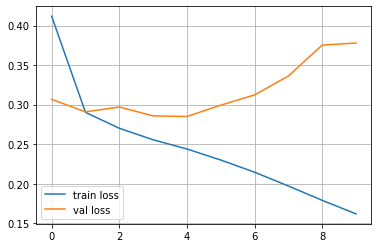

In [ ]:
steps = range(len(h2.history['loss']))
plt.plot(steps, h2.history['loss'], label='train loss')
plt.plot(steps, h2.history['val_loss'], label='val loss')
plt.legend()
plt.grid()

That change didn't improve our result, and model was overfitted

Model with deleted stop words

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
normalized_toxic['comment_text'] = normalized_toxic['comment_text'].apply(lambda x: ' '.join([word for word in x.lower().split() if word not in (stop_words)]))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# let's create train and test set
y = normalized_toxic['binary_target'].values
X = normalized_toxic['comment_text'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)


In [ ]:
tokenizer = Tokenizer(num_words=15000, lower=True)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_test)

X_train_seq = pad_sequences(X_train_seq, maxlen=200, padding='pre', truncating='pre') # pre or post
X_val_seq = pad_sequences(X_val_seq, maxlen=200, padding='pre', truncating='pre') # pre or post

In [ ]:
model11 = keras.Sequential()

model11.add(GloveEmbeddings(embedding_dim=200, trainable=False, tokenizer=tokenizer))
model11.add(layers.Bidirectional(layers.LSTM(30,return_sequences=True)))   #20
model11.add(layers.Dropout(0.3)) #0.2
model11.add(layers.LSTM(30)) #20
model11.add(layers.Dropout(0.2)) #-
model11.add(layers.Dense(1, activation='sigmoid'))

adam = keras.optimizers.Adam(learning_rate=0.001) # 
model11.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

Found 400000 word vectors.
Converted 71605 words (58401 misses)


In [ ]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

h11 = model11.fit(x=X_train_seq, y=y_train, batch_size=512, epochs=100, validation_data=(X_val_seq, y_test),
               callbacks=[es_callback])

Epoch 1/100
452/452 [==============================] - 34s 49ms/step - loss: 0.4006 - accuracy: 0.8204 - val_loss: 0.3376 - val_accuracy: 0.8577
Epoch 2/100
452/452 [==============================] - 21s 46ms/step - loss: 0.3213 - accuracy: 0.8649 - val_loss: 0.3114 - val_accuracy: 0.8699
Epoch 3/100
452/452 [==============================] - 21s 47ms/step - loss: 0.3016 - accuracy: 0.8749 - val_loss: 0.3295 - val_accuracy: 0.8644
Epoch 4/100
452/452 [==============================] - 21s 47ms/step - loss: 0.2909 - accuracy: 0.8806 - val_loss: 0.2980 - val_accuracy: 0.8769
Epoch 5/100
452/452 [==============================] - 21s 48ms/step - loss: 0.2839 - accuracy: 0.8836 - val_loss: 0.2932 - val_accuracy: 0.8784
Epoch 6/100
452/452 [==============================] - 22s 48ms/step - loss: 0.2773 - accuracy: 0.8861 - val_loss: 0.2963 - val_accuracy: 0.8802
Epoch 7/100
452/452 [==============================] - 21s 47ms/step - loss: 0.2725 - accuracy: 0.8887 - val_loss: 0.2923 - val_ac

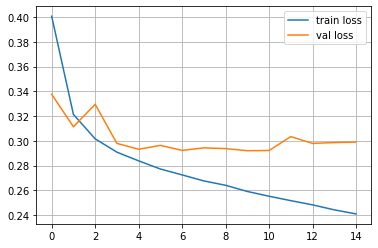

In [ ]:
steps = range(len(h11.history['loss']))
plt.plot(steps, h11.history['loss'], label='train loss')
plt.plot(steps, h11.history['val_loss'], label='val loss')
plt.legend()
plt.grid()

Model with deleted stop words wasn't better from previous models

Now I will create model to predict exact toxicity. For this model all the data will be used.

In [6]:
#  let's create train and test set
y = toxic['target'].values
X = toxic['comment_text'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


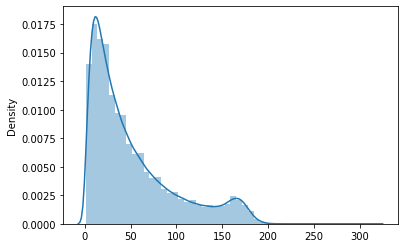

In [ ]:
train_lens = [len(x.split()) for x in X_train]
ax = sns.distplot(train_lens)

In [7]:
tokenizer = Tokenizer(num_words=15000, lower=True)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_test)

X_train_seq = pad_sequences(X_train_seq, maxlen=200, padding='pre', truncating='pre') # pre or post
X_val_seq = pad_sequences(X_val_seq, maxlen=200, padding='pre', truncating='pre') # pre or post


In [ ]:
vocab_size = len(tokenizer.word_index) + 1
embedding_vector_length = 16

In [ ]:
#model for predicting exact toxicity
model4 = keras.Sequential()

model4.add(layers.Embedding(vocab_size, embedding_vector_length, input_length=200) )
model4.add(layers.Bidirectional(layers.LSTM(30,return_sequences=True)))
model4.add(layers.Dropout(0.5))
model4.add(layers.Bidirectional(layers.LSTM(30)))
model4.add(layers.Dropout(0.2))
model4.add(layers.Dense(1, activation='linear'))

adam = keras.optimizers.Adam(learning_rate=0.001) # 
model4.compile(loss='mean_absolute_error', optimizer=adam, metrics=['mean_absolute_error'])


In [ ]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

h4 = model4.fit(x=X_train_seq, y=y_train, batch_size=1024, epochs=100, validation_data=(X_val_seq, y_test),
               callbacks=[es_callback])

Epoch 1/100
1411/1411 [==============================] - 122s 82ms/step - loss: 0.0836 - mean_absolute_error: 0.0836 - val_loss: 0.0693 - val_mean_absolute_error: 0.0693
Epoch 2/100
1411/1411 [==============================] - 115s 82ms/step - loss: 0.0703 - mean_absolute_error: 0.0703 - val_loss: 0.0674 - val_mean_absolute_error: 0.0674
Epoch 3/100
1411/1411 [==============================] - 114s 81ms/step - loss: 0.0677 - mean_absolute_error: 0.0677 - val_loss: 0.0667 - val_mean_absolute_error: 0.0667
Epoch 4/100
1411/1411 [==============================] - 114s 81ms/step - loss: 0.0665 - mean_absolute_error: 0.0665 - val_loss: 0.0660 - val_mean_absolute_error: 0.0660
Epoch 5/100
1411/1411 [==============================] - 122s 86ms/step - loss: 0.0656 - mean_absolute_error: 0.0656 - val_loss: 0.0665 - val_mean_absolute_error: 0.0665
Epoch 6/100
1411/1411 [==============================] - 115s 82ms/step - loss: 0.0648 - mean_absolute_error: 0.0648 - val_loss: 0.0664 - val_mean_abs

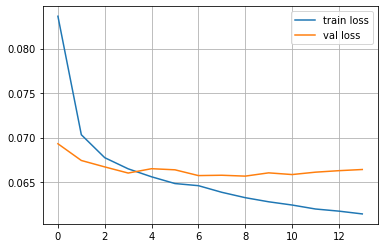

In [ ]:
steps = range(len(h4.history['loss']))
plt.plot(steps, h4.history['loss'], label='train loss')
plt.plot(steps, h4.history['val_loss'], label='val loss')
plt.legend()
plt.grid()

In [ ]:
print(y_test.mean(), np.median(y_test))

0.10349316410106624 0.0


It looks like the mae for the model is quite high. Let's try how the decision tree is performing on this dataset.

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

regr = DecisionTreeRegressor(max_depth=15, random_state=0)
regr.fit(X_train_seq, y_train)

y_pred = regr.predict(X_val_seq)
mae = mean_absolute_error(y_test, y_pred)
print(f'Tree MAE: {mae}')

Tree MAE: 0.13900396117404626


Decision tree model is much worse than the neural network that I used.